References:

1. https://github.com/xbresson/CS6208_2023/blob/main/codes/labs_lecture07/01_vanilla_graph_transformers.ipynb
2. https://github.com/xbresson/CS6208_2023/blob/main/codes/labs_lecture07/03_graph_transformers_regression_exercise.ipynb
3. https://github.com/pgniewko/pytorch_geometric/blob/master/torch_geometric/nn/conv/transformer_conv.py
4. https://arxiv.org/abs/2012.09699
5. https://arxiv.org/abs/1703.04977

TDC:
1. Test the model on this new set: https://practicalcheminformatics.blogspot.com/2023/06/getting-real-with-molecular-property.html

In [1]:
import pandas as pd

import weightwatcher as ww

from tdc.single_pred import ADME
from rdkit import RDLogger
from rdkit import rdBase
from rdkit import Chem
import rdkit
import torch
import math
import torch.nn.functional as F
import numpy as np
from torch import nn
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_scatter.composite import scatter_softmax
from torch_scatter.scatter import scatter_add
from torch_geometric.utils import softmax
from torch_geometric.nn.resolver import activation_resolver
from torch_geometric.nn.aggr import MultiAggregation
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
import os.path as osp
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.utils import degree
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Turn off majority of RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

print(f'Rdkit version: {rdkit.__version__}')
print(f'Torch version: {torch.__version__}')

from gt_pyg.data.utils import get_tensor_data, get_node_dim, get_edge_dim, get_train_valid_test_data

from gt_pyg.nn.model import GraphTransformerNet


torch.manual_seed(192837465)

PyTorch is available but CUDA is not. Defaulting to SciPy for SVD
INFO:rdkit:Enabling RDKit 2022.09.5 jupyter extensions


Rdkit version: 2022.09.5
Torch version: 1.13.1


## Get the ADME@TDC data 

In [2]:
PE_DIM = 6
(tr, va, te) = get_train_valid_test_data('Caco2_Wang', min_num_atoms=PE_DIM + 1)
tr_dataset = get_tensor_data(tr.Drug.to_list(), tr.Y.to_list(), pe_dim=PE_DIM)
va_dataset = get_tensor_data(va.Drug.to_list(), va.Y.to_list(), pe_dim=PE_DIM)
te_dataset = get_tensor_data(te.Drug.to_list(), te.Y.to_list(), pe_dim=PE_DIM)
NODE_DIM = get_node_dim()
EDGE_DIM = get_edge_dim()

print(f'Number of training examples: {len(tr_dataset)}')
print(f'Number of validation examples: {len(va_dataset)}')
print(f'Number of test examples: {len(te_dataset)}')

train_loader = DataLoader(tr_dataset, batch_size=128)
val_loader = DataLoader(va_dataset, batch_size=128)
test_loader = DataLoader(te_dataset, batch_size=128)

Found local copy...
Loading...
Done!


Number of training examples: 628
Number of validation examples: 89
Number of test examples: 178


## Train and eval the GT model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=4, 
                            hidden_dim=200,
                            norm='bn',
                            aggregators=['sum','mean','max', 'std'],
                            dropout=0.1,
                            act='gelu').to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model = torch_geometric.compile(model) 

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)


print(model)
print(f"Number of params: {model.num_parameters()//1000}k")

def train(epoch, loss_func):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * ( 2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0) 

        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader, loss_func):
    model.eval()

    total_error = 0
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0) 
        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
        total_error += loss_func(out.squeeze(), data.y).item()
    return total_error / len(loader.dataset)

train_loss = nn.L1Loss(reduction='mean')
test_loss = nn.L1Loss(reduction='sum')

for epoch in range(1, 11):
    tr_loss = train(epoch, loss_func=train_loss)
    va_loss = test(val_loader, loss_func=test_loss)
    te_loss = test(test_loader, loss_func=test_loss)
    scheduler.step(va_loss)
    print(f'Epoch: {epoch:02d}, Loss: {tr_loss:.4f}, Val: {va_loss:.4f}, '
          f'Test: {te_loss:.4f}')

GraphTransformerNet(
  (node_emb): Linear(in_features=79, out_features=200, bias=True)
  (edge_emb): Linear(in_features=10, out_features=200, bias=True)
  (pe_emb): Linear(in_features=6, out_features=200, bias=True)
  (gt_layers): ModuleList(
    (0): GTConv(200, 200, heads=8)
    (1): GTConv(200, 200, heads=8)
    (2): GTConv(200, 200, heads=8)
    (3): GTConv(200, 200, heads=8)
  )
  (global_pool): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
    MaxAggregation(),
    StdAggregation(),
  ], mode=cat)
  (mu_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=800, out_features=200, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=200, out_features=1, bias=True)
    )
  )
  (std_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=800, out_features=200, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=200, out_features=1, bias=True)
    )
  )
)
Number of params: 1954k
torch.Size([3862, 79])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/Users/pawel/anaconda3/envs/gt/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/4b/hq3_lmzj215_hw29qxb407dc0000gn/T/ipykernel_97560/22779266.py", line 59, in <module>
    tr_loss = train(epoch, loss_func=train_loss)
  File "/var/folders/4b/hq3_lmzj215_hw29qxb407dc0000gn/T/ipykernel_97560/22779266.py", line 34, in train
    (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
  File "/Users/pawel/anaconda3/envs/gt/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/pawel/projects/gt-pyg/gt_pyg/nn/model.py", line 97, in forward
    (x, edge_attr) = gt_layer(x, edge_index, edge_attr=edge_attr)
  File "/Users/pawel/anaconda3/envs/gt/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return fo

TypeError: object of type 'NoneType' has no len()

## STD vs ERROR

In [21]:
#@torch.no_grad()
model.eval()

y_hat = []
y_exp = []

stds = []

for data in test_loader:
    data = data.to(device)
        # randomly flip sign of eigenvectors
    batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0) 
    (out, std) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
        #total_error += loss_func(out.squeeze(), data.y).item()
    y_hat += list(out.squeeze().detach().numpy())
    y_exp += list(data.y.detach().numpy())
    stds += list(std.detach().numpy())


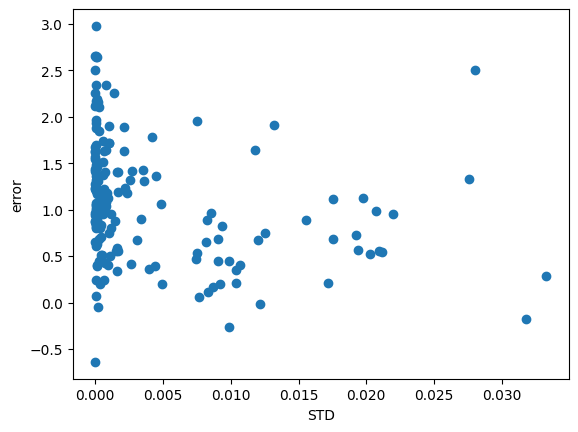

In [26]:
import matplotlib.pyplot as plt
plt.scatter(stds, np.array(y_hat) - np.array(y_exp))
plt.xlabel('STD')
plt.ylabel('error')
plt.show()

In [3]:
torch.zeros_like(torch.tensor([1,2,3,4]))

tensor([0, 0, 0, 0])

ERROR! Session/line number was not unique in database. History logging moved to new session 358
